Import

In [41]:
# 1. IMPORT LIBRARIES & DEPENDENCIES
# Pada bagian ini, digunakan untuk memuat semua library yang dibutuhkan untuk pengolahan data,
# pembuatan model Deep Learning, hingga visualisasi hasil evaluasi.

# Core Deep Learning Framework (PyTorch)
import torch
import torchvision
from torch import nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data Handling & Komputasi Nummerik
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Utilities
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

# Utility $ System Module
import os
import random
from tqdm.auto import tqdm
from typing import List, Dict, Tuple, Union
from timeit import default_timer as timer

# Model Summary Tool
# untuk mengecek apakah di dalam sistem sudah terdapat torchinfp
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo. Installing.")
    !pip install -q torchinfo
    from torchinfo import summary

Cek Versi pytorch

In [42]:
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.10.0+cpu
torchvision version: 0.25.0+cpu


Setup Device

In [43]:
# untuk mengecek apakah device yang digunakan menggunakan cpu ataupun cuda
device = "cuda" if torch.cuda.is_available() == True else "cpu"
device

'cpu'

Link path ke Drive

In [44]:
import zipfile
from google.colab import drive
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# akses google drive untuk menarik dataset
drive.mount('/content/drive')

# lalu diekstrak ke penyimpanan lokal collab
zip_path = '/content/drive/MyDrive/roaddamage_detection/dataset_sampel.zip'
extract_path = '/content/dataset_pothole'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# preprocessing awal untuk gambar
# standarisasi gambarnya menjadi 224x224
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

full_dataset_path = "/content/dataset_pothole/dataset_sampel"

dataset = datasets.ImageFolder(root=full_dataset_path, transform=data_transforms)

print(f"Kelas yang ditemukan: {dataset.classes}")
print(f"Total gambar: {len(dataset)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Kelas yang ditemukan: ['normal', 'potholes']
Total gambar: 100


Ambil data

Random Image Path: /content/dataset_pothole/dataset_sampel/normal/46.jpg
Image Class: normal | Height: 316 | Width: 500


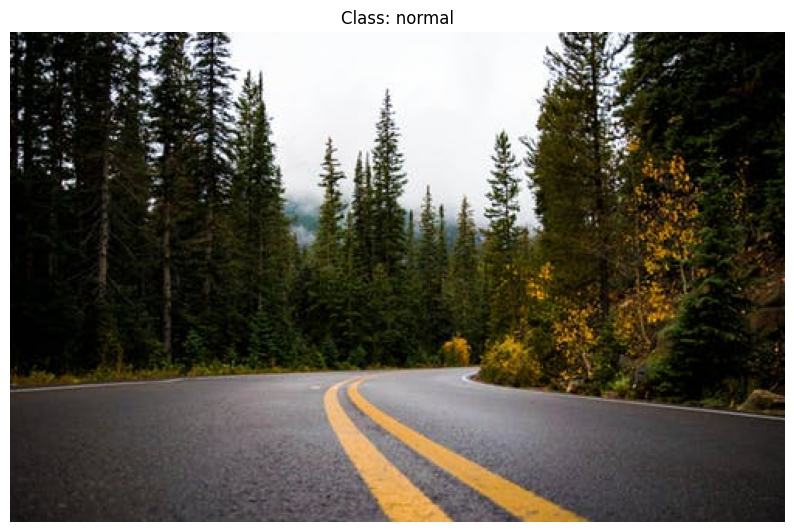

In [45]:
from pathlib import Path
import random
from PIL import Image
import matplotlib.pyplot as plt

# Tentukan lokasi folder dataset
image_path = Path("/content/dataset_pothole/dataset_sampel")

# Ambil semua file gambar dan filter ekstensinya
# (untuk mencegah error kalau ada hidden file yang ikut terbaca)
image_path_list = list(image_path.glob("*/*"))
image_path_list = [path for path in image_path_list if path.suffix.lower() in [".jpg", ".jpeg", ".png"]]

# Cek apakah gambar berhasil ditemukan
if len(image_path_list) == 0:
    print("Peringatan: Tidak ada gambar ditemukan. Pastikan path sudah benar.")
else:
    # Pilih satu gambar secara acak untuk dicek visual dan ukurannya
    random_image_path = random.choice(image_path_list)

    # Ambil nama kelas langsung dari nama foldernya
    image_class = random_image_path.parent.stem
    img = Image.open(random_image_path)

    print(f"Random Image Path: {random_image_path}")
    print(f"Image Class: {image_class} | Height: {img.height} | Width: {img.width}")

    # Tampilkan gambarnya
    plt.figure(figsize=(10, 7))
    plt.imshow(img)
    plt.title(f"Class: {image_class}")
    plt.axis(False)
    plt.show()

Membagi Folder

In [46]:
import os
import shutil
import random
from pathlib import Path

root_dir = '/content/dataset_pothole/dataset_sampel'
base_dir = '/content/dataset_split'
classes = ['normal', 'potholes']

# 1. Siapkan struktur folder untuk Train dan Test
for cls in classes:
    os.makedirs(os.path.join(base_dir, 'train', cls), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'test', cls), exist_ok=True)

# 2. Lakukan Train-Test Split (80% Train, 20% Test) dengan seed tetap untuk reproducibility
split_ratio = 0.8

for cls in classes:
    src_path = os.path.join(root_dir, cls)
    all_files = os.listdir(src_path)

    random.seed(42)
    random.shuffle(all_files)

    train_count = int(len(all_files) * split_ratio)
    train_files = all_files[:train_count]
    test_files = all_files[train_count:]

    # 3. Distribusikan file ke masing-masing folder
    for f in train_files:
        shutil.copy(os.path.join(src_path, f), os.path.join(base_dir, 'train', cls, f))

    for f in test_files:
        shutil.copy(os.path.join(src_path, f), os.path.join(base_dir, 'test', cls, f))

print("Proses pembagian folder selesai!")

Proses pembagian folder selesai!


Pre Procesing

In [47]:
# 1. Setup Transformasi (Menggunakan standar normalisasi ImageNet)
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Augmentasi ringan khusus data training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test set tidak di-augmentasi agar evaluasi tetap objektif
test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dir = "/content/dataset_split/train"
test_dir = "/content/dataset_split/test"

train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

# 2. Setup DataLoader (Shuffle wajib True untuk train agar model tidak menghafal urutan)
BATCH_SIZE = 8
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Resize berhasil diterapkan! Ukuran Tensor: {train_data[0][0].shape}")

Resize berhasil diterapkan! Ukuran Tensor: torch.Size([3, 224, 224])


Generate Random Image hasil Pre Procesing

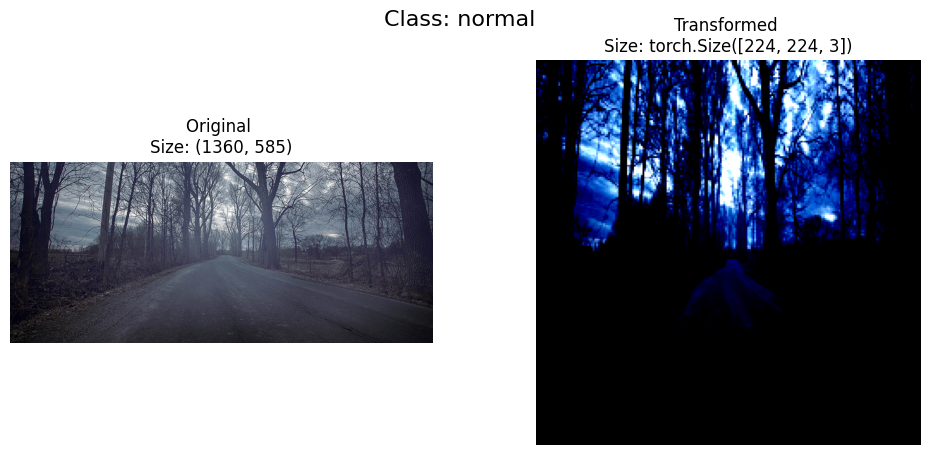

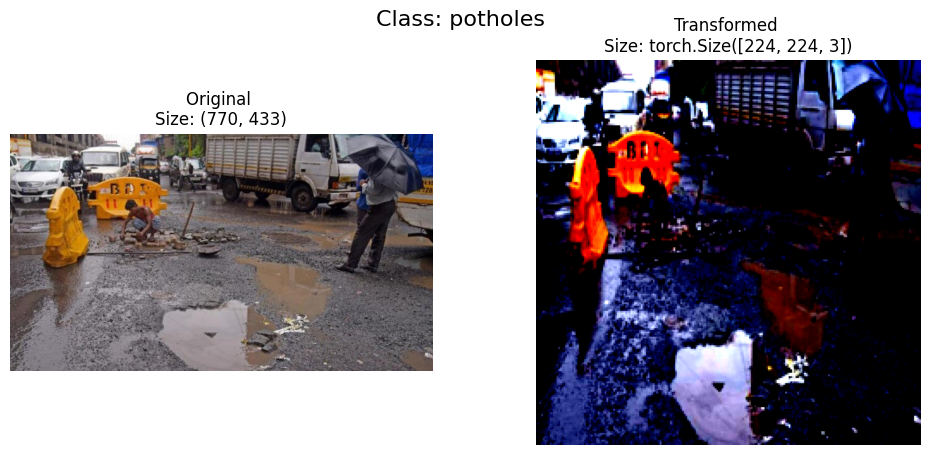

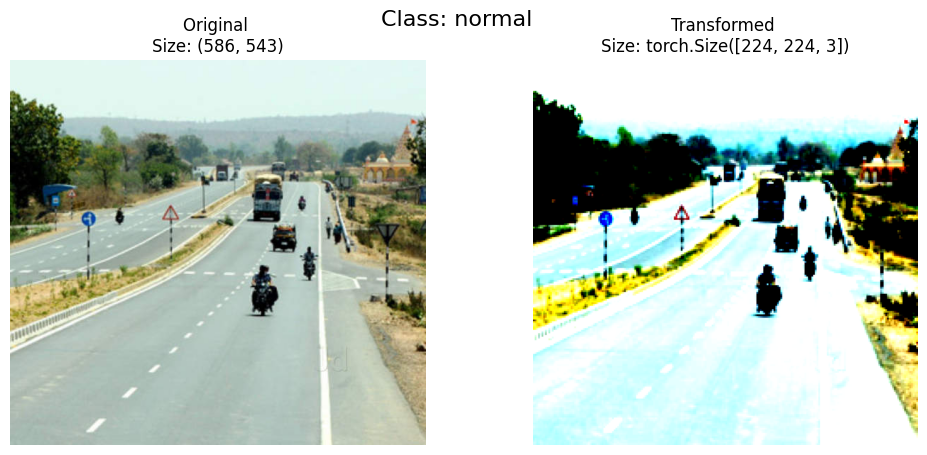

In [48]:
import random
import torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

train_path = Path("/content/dataset_split/train")
image_path_list = list(train_path.glob("*/*.jpg"))

# Visualisasi augmentasi untuk memastikan data siap sebelum masuk ke model (Sanity Check)
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2, figsize=(12, 5))

            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Matplotlib membaca gambar dalam format (Height, Width, Channel)
            transformed_image = transform(f).permute(1, 2, 0)

            # Normalisasi ImageNet mengubah range nilai pixel
            transformed_image = torch.clamp(transformed_image, 0, 1)

            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
            plt.show()

plot_transformed_images(image_path_list, transform=train_transform, n=3)

DataLoader

In [49]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoader siap! Jumlah batch per epoch: {len(train_dataloader)}")

DataLoader siap! Jumlah batch per epoch: 10


arsitektur model CNN utama

In [50]:
from torch import nn

class PotholeModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Input 224x224 dibagi 2 oleh MaxPool menjadi 112x112
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 112 * 112, out_features=output_shape)
        )

    def forward(self, x):
        return self.classifier(self.block_1(x))

# Inisialisasi model
model_pothole = PotholeModel(input_shape=3, hidden_units=10, output_shape=2).to(device)

# Cek struktur dan total parameter model
from torchinfo import summary
summary(model_pothole, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
PotholeModel                             [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 10, 224, 224]         280
│    └─ReLU: 2-2                         [1, 10, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 10, 224, 224]         910
│    └─ReLU: 2-4                         [1, 10, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 10, 112, 112]         --
├─Sequential: 1-2                        [1, 2]                    --
│    └─Flatten: 2-6                      [1, 125440]               --
│    └─Linear: 2-7                       [1, 2]                    250,882
Total params: 252,072
Trainable params: 252,072
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 59.96
Input size (MB): 0.60
Forward/backward pass size (MB): 8.03
Params size (MB): 1.01
Estimated Total Size (

optimizer

In [51]:
# Loss function standar untuk klasifikasi (karena output model berupa raw logits)
loss_fn = nn.CrossEntropyLoss()

# Optimizer menggunakan Adam dengan learning rate standar 1e-3
optimizer = torch.optim.Adam(params=model_pothole.parameters(), lr=0.001)

Epoch

In [52]:
from timeit import default_timer as timer

epochs = 15
start_time = timer()

for epoch in range(epochs):
    # Wajib di-set ke mode training (penting jika nanti pakai Dropout/BatchNorm)
    model_pothole.train()
    train_loss = 0

    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        y_pred = model_pothole(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Standar urutan PyTorch untuk backpropagation & update bobot
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Cetak rata-rata loss per epoch
    print(f"Epoch: {epoch+1}/{epochs} | Loss: {train_loss/len(train_dataloader):.4f}")

end_time = timer()
print(f"Total waktu training: {end_time - start_time:.3f} detik")

Epoch: 1/15 | Loss: 1.5402
Epoch: 2/15 | Loss: 0.3650
Epoch: 3/15 | Loss: 0.3576
Epoch: 4/15 | Loss: 0.1612
Epoch: 5/15 | Loss: 0.1030
Epoch: 6/15 | Loss: 0.1219
Epoch: 7/15 | Loss: 0.1018
Epoch: 8/15 | Loss: 0.0604
Epoch: 9/15 | Loss: 0.0327
Epoch: 10/15 | Loss: 0.0253
Epoch: 11/15 | Loss: 0.0114
Epoch: 12/15 | Loss: 0.0069
Epoch: 13/15 | Loss: 0.0044
Epoch: 14/15 | Loss: 0.0033
Epoch: 15/15 | Loss: 0.0023
Total waktu training: 61.547 detik


Hasil Evaluasi

In [53]:
# Wajib di-set ke mode evaluasi agar layer seperti Dropout/BatchNorm tidak aktif saat testing
model_pothole.eval()
test_loss, test_acc = 0, 0

# Matikan tracking gradien (sangat penting untuk menghemat memori dan mempercepat evaluasi)
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)

        test_pred_logits = model_pothole(X)

        loss = loss_fn(test_pred_logits, y)
        test_loss += loss.item()

        # Ubah output raw logits menjadi label prediksi (mengambil indeks dengan nilai probabilitas tertinggi)
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

# Hitung rata-rata loss dan akurasi per batch
test_loss = test_loss / len(test_dataloader)
test_acc = test_acc / len(test_dataloader)

print(f"Hasil Evaluasi:")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc*100:.2f}%")

Hasil Evaluasi:
Test Loss: 0.1307 | Test Accuracy: 91.67%


Visualisasi Prediksi

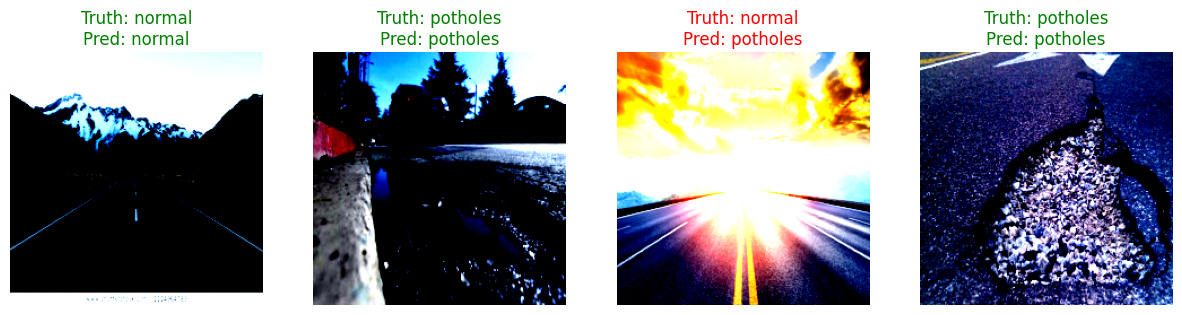

In [54]:
import random

def plot_predictions(model, dataset, n=3):
    model.eval()
    plt.figure(figsize=(15, 10))

    for i in range(n):
        random_idx = random.randint(0, len(dataset)-1)
        img, label = dataset[random_idx]

        # Tambahkan dimensi batch (B, C, H, W) sebelum masuk ke model
        img_tensor = img.unsqueeze(dim=0).to(device)

        with torch.inference_mode():
            pred_logits = model(img_tensor)
            pred_label = pred_logits.argmax(dim=1).item()

        plt.subplot(1, n, i+1)

        # Kembalikan ke CPU dan ubah urutan channel ke (H, W, C) agar bisa di-plot Matplotlib
        display_img = img.permute(1, 2, 0).cpu()
        display_img = torch.clamp(display_img, 0, 1)

        plt.imshow(display_img)
        title_color = "green" if pred_label == label else "red"
        plt.title(f"Truth: {dataset.classes[label]}\nPred: {dataset.classes[pred_label]}", color=title_color)
        plt.axis(False)

plot_predictions(model_pothole, test_data, n=4)

Fungsi Training dengan pencatatan History

In [55]:
import torch
from tqdm.auto import tqdm
from timeit import default_timer as timer

def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 15
start_time = timer()

model_pothole = PotholeModel(input_shape=3, hidden_units=10, output_shape=2).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_pothole.parameters(), lr=0.001)

print("Memulai Training dengan Pencatatan Riwayat...")
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model_pothole,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model_pothole,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}")

end_time = timer()
print(f"Total waktu training: {end_time - start_time:.3f} detik")

Memulai Training dengan Pencatatan Riwayat...


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.2962 | train_acc: 0.5250 | test_loss: 1.2960 | test_acc: 0.7500
Epoch: 2 | train_loss: 0.7683 | train_acc: 0.7375 | test_loss: 0.4181 | test_acc: 0.7500
Epoch: 3 | train_loss: 0.3157 | train_acc: 0.8750 | test_loss: 0.2475 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.3110 | train_acc: 0.8750 | test_loss: 0.4465 | test_acc: 0.8333
Epoch: 5 | train_loss: 0.1993 | train_acc: 0.9250 | test_loss: 0.6993 | test_acc: 0.7500
Epoch: 6 | train_loss: 0.1894 | train_acc: 0.9125 | test_loss: 0.4526 | test_acc: 0.7500
Epoch: 7 | train_loss: 0.0782 | train_acc: 1.0000 | test_loss: 0.7438 | test_acc: 0.7917
Epoch: 8 | train_loss: 0.0568 | train_acc: 1.0000 | test_loss: 0.5093 | test_acc: 0.8333
Epoch: 9 | train_loss: 0.0444 | train_acc: 1.0000 | test_loss: 0.4578 | test_acc: 0.8333
Epoch: 10 | train_loss: 0.0390 | train_acc: 0.9875 | test_loss: 0.4973 | test_acc: 0.7917
Epoch: 11 | train_loss: 0.0274 | train_acc: 1.0000 | test_loss: 0.3301 | test_acc: 0.8333
Epoch: 12 | train_l

Visualisasi

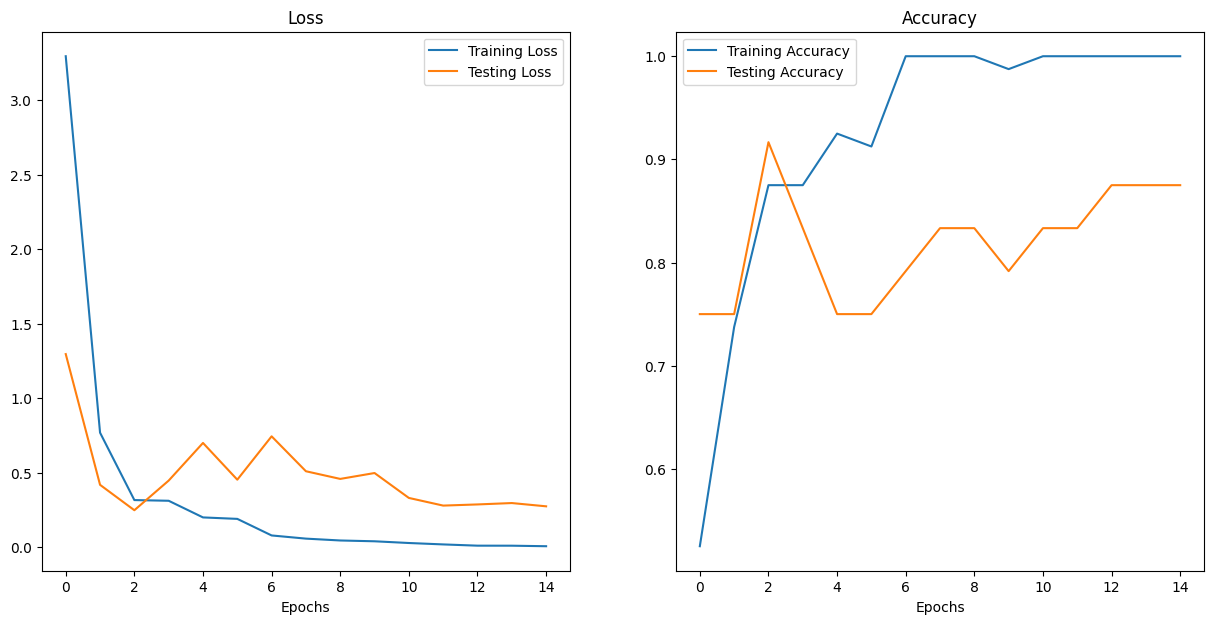

In [56]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    """Memplot kurva loss dan akurasi dari dictionary results."""

    train_loss = results['train_loss']
    test_loss = results['test_loss']

    train_accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, test_loss, label='Testing Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, test_accuracy, label='Testing Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()

plot_loss_curves(results)

evaluasi akhir dengan confusion Matrix

<Figure size 800x600 with 0 Axes>

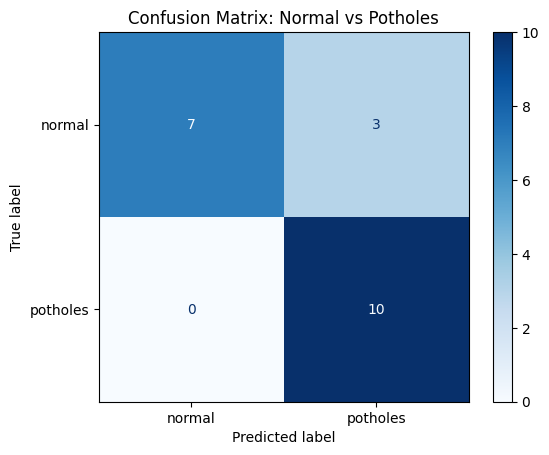

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model_pothole.eval()
y_preds = []
y_true = []

with torch.inference_mode():
    for X, y in test_dataloader:
        X = X.to(device)
        logits = model_pothole(X)
        preds = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        y_preds.extend(preds.cpu().numpy())
        y_true.extend(y.numpy())

cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix: Normal vs Potholes")
plt.show()

Dengan gambar baru

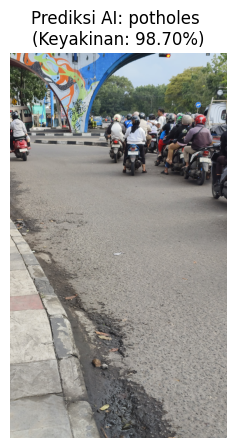

In [58]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

def predict_new_image(image_path, model, transform, class_names):
    # Buka gambar sesuai dengan path yang diberikan di parameter
    img = Image.open(image_path)

    transformed_image = transform(img).unsqueeze(dim=0).to(device)

    model.eval()
    with torch.inference_mode():
        logits = model(transformed_image)

        # Ubah output raw logits menjadi nilai probabilitas (0-1) untuk menghitung persentase keyakinan
        pred_prob = torch.softmax(logits, dim=1)
        pred_label = torch.argmax(pred_prob, dim=1).item()

    plt.figure(figsize=(8, 5))
    plt.imshow(img)
    plt.title(f"Prediksi AI: {class_names[pred_label]} \n(Keyakinan: {torch.max(pred_prob)*100:.2f}%)")
    plt.axis(False)
    plt.show()

# Uji coba dengan gambar baru dari luar dataset
predict_new_image(image_path="/content/picture3.jpg",
                  model=model_pothole,
                  transform=test_transform,
                  class_names=train_data.classes)